# INITIALISATION 

## Premium Absorption Signal: 
A sharp buy volume spike (on your middle chart) occurs precisely as the price hits the cyan line (upper bound) of the SELL volume profile. If the price fails to break through, this is your highest-probability short signal. (The inverse is true for a long).

## Imminent V-Reversal: 
The yellow and cyan lines on a profile overlap or cross. This signals the structure has changed from a "zone" to a single, critical "Point of Control". Mark this price; it's a magnet and a powerful pivot for sharp reversals.

## Trend Continuation Setup:
The profile is split/inverted (e.g., yellow line is below the cyan line). Do not look for a reversal. Instead, watch for the price to pull back to the edge of the nearest value area and look for a continuation entry in the direction of the initial trend.

## Bullish Structure Confirmation: 
The primary HVN (zone between yellow/cyan) of the Buy Profile is at a lower price than the HVN of the Sell Profile. Favor long entries on pullbacks to the Buy Profile's value area.

## Bearish Structure Warning (Bull Trap): 
The primary HVN of the Buy Profile is above the HVN of the Sell Profile. Be very cautious with longs. This is a setup for a potential failure, making short entries on failed rallies more attractive.

## Acceptance in a "Red Zone" (LVN):
 Price normally moves quickly through red zones (Low-Volume Nodes). If the price stalls and begins to build volume within a red zone, it's a major change. The market is now accepting prices it previously rejected, often preceding a new trend.

## High-Volume Stall:
 You see a massive spike on your middle "DIFF" chart, but the price itself stops moving. This indicates a fierce battle. Don't trade during the stall; trade in the direction of the winner once price breaks out of this tight range.

## Diminishing Volume on Repeated Tests: 
Price attacks a key boundary (e.g., a cyan line) multiple times, but each corresponding volume spike is weaker than the last. This shows buyer/seller exhaustion and increases the probability that the next test will fail and reverse.

## The "Ledge" Test: 
A profile isn't smooth but has a sharp drop-off, creating a high-volume "ledge" above a low-volume area. These ledges are often weak structurally. A price break below the ledge is often a high-momentum trade targeting the next high-volume area below.

## The Gap Jump: 
After a profile splits, if the price jumps from the top of the lower value area to the bottom of the higher value area, watch the boundaries of that gap. A future re-test of the edge it broke away from is a classic trend-following entry point.

# Premium Absorption

In [5]:
import StockAnalyser
class PremiumAbsorption(StockAnalyser.Cumulative_Support):
    def __init__(self):
        super().__init__()
        self.monitoring= False
        self.trades_to_collect = 10
        self.collected_trades = []
        # implement timestamp based exit too
        self.shorts = []
        self.riding_peak=False
        self.mean_range = 50
        self.multiplier = 3
        self.dominance_ratio = 2

    def Check(self,vol_type,vol,index,ltp):
        peak = self.peak() # keep monitoring for peak continually. 

        if self.monitoring:
            print("we're monitoring")
            self.collected_trades.append((vol_type,vol))
            if len(self.collected_trades) == self.trades_to_collect:
                rejection = self.Analyse()
                if rejection:
                    print(f'we got a rejection boys {index}:{ltp}')
                    self.shorts.append((index,ltp))
                else:
                    print(f'no rejection at {index}:{ltp}')
                self.reset()
                
        else:
            inResistance = self.inResistance(ltp)
            if inResistance:
                print(f"we're in resistance,{index}:{ltp}")
            
            if inResistance and peak:
                print("peak and spike detected")
                self.monitoring = True
                self.collected_trades.clear()
                print("spike detected, looking for premium absorption")

    def peak(self):
        if len(self.voldiff_buy)<self.mean_range:
            return False
        mean = self.voldiff_buy.iloc[-self.mean_range:].mean()[0]
        std = self.voldiff_buy.iloc[-self.mean_range:].std()[0]
        if self.voldiff_buy.iloc[-1][0]>mean+std*self.multiplier and not self.riding_peak:
            self.riding_peak=True
            return True
        if self.voldiff_buy.iloc[-1][0]<=mean+std*self.multiplier and self.riding_peak:
            self.riding_peak=False
            #print(f"peak ended at {self.voldiff_buy.index[-1]},ltpvalue:{self.voldiff_buy.iloc[-1]}\n")
            return False
         
    def reset(self):
        self.monitoring = False
        self.trades_to_collect = 9
        self.collected_trades = [] #(0|1,vol) 0 for buy, 1 for sell
        
    def Analyse(self):
        total_sell = sum([x[1] for x in self.collected_trades if x[0]=='s'])
        total_buy = sum([x[1] for x in self.collected_trades if x[0]=='b'])
        if total_buy ==0:
            return True # total seller dominance 
        
        return total_sell/total_buy>self.dominance_ratio # only return true if sellers dominate significantly. 

    def inResistance(self,current_ltp):
        return self.combineddf[1].iloc[:,-1].loc[current_ltp]==2

    def parse(self,message):
        super().parse(message)
        self.Check(self.ltp_type,self.delta,len(self.ltpDf),self.ltpDf.iloc[-1]['ltp'])
        


# MODIFIED: Renamed to a general-purpose class
class AbsorptionSignalFinder(StockAnalyser.Cumulative_Support):
    def __init__(self):
        super().__init__()
        # MODIFIED: Upgraded monitoring to a state string
        self.monitoring_state = "IDLE" 
        self.trades_to_collect = 10
        self.collected_trades = []
        
        # We now track both long and short signals
        self.shorts = []
        self.longs = []
        
        # MODIFIED: Separate state flags for each peak type
        self.riding_buy_peak = False
        self.riding_sell_peak = False
        
        self.mean_range = 50
        self.multiplier = 3
        self.dominance_ratio = 2

    def Check(self, vol_type, vol, index, ltp):
        # --- PART 1: HANDLE ACTIVE MONITORING FIRST ---
        if self.monitoring_state != "IDLE":
            self.collected_trades.append((vol_type, vol))
            
            if len(self.collected_trades) >= self.trades_to_collect:
                # Analyze trades based on which signal we were monitoring
                direction = "SHORT" if self.monitoring_state == "MONITORING_SHORT" else "LONG"
                result = self.Analyse(direction)
                
                if result:
                    print(f'ABSORPTION CONFIRMED ({direction}) at {index}:{ltp}')
                    if direction == "SHORT":
                        self.shorts.append((index, ltp))
                    else:
                        self.longs.append((index, ltp))
                else:
                    print(f'No absorption confirmed at {index}:{ltp}')
                
                self.reset()
            return # Do nothing else while monitoring

        # --- PART 2: IF IDLE, LOOK FOR NEW SIGNALS ---
        # Check for a short setup
        in_res = self.inResistance(ltp)
        if in_res and self.buy_peak():
            print("Buy spike in resistance zone! Starting SHORT monitoring...")
            self.monitoring_state = "MONITORING_SHORT"
            self.collected_trades.clear()
            return

        # Check for a long setup
        in_sup = self.inSupport(ltp)
        if in_sup and self.sell_peak():
            print("Sell spike in support zone! Starting LONG monitoring...")
            self.monitoring_state = "MONITORING_LONG"
            self.collected_trades.clear()
            return
            
        # If price is not in a zone, reset peak flags to allow re-triggering later
        if not in_res: self.riding_buy_peak = False
        if not in_sup: self.riding_sell_peak = False

    # MODIFIED: Renamed for clarity, checks for buy volume spike
    def buy_peak(self):
        if len(self.voldiff_buy) < self.mean_range: return False
        mean = self.voldiff_buy.iloc[-self.mean_range:].mean()[0]
        std = self.voldiff_buy.iloc[-self.mean_range:].std()[0]
        
        if self.voldiff_buy.iloc[-1][0] >= mean + std * self.multiplier and not self.riding_buy_peak:
            self.riding_buy_peak = True
            return True
        return False

    # MODIFIED: Renamed for clarity, checks for sell volume spike
    def sell_peak(self):
        if len(self.voldiff_sell) < self.mean_range: return False
        mean = self.voldiff_sell.iloc[-self.mean_range:].mean()[0]
        std = self.voldiff_sell.iloc[-self.mean_range:].std()[0]
        
        if self.voldiff_sell.iloc[-1][0] >= mean + std * self.multiplier and not self.riding_sell_peak:
            self.riding_sell_peak = True
            return True
        return False
         
    def reset(self):
        self.monitoring_state = "IDLE"
        self.collected_trades = []
        
    # MODIFIED: Now takes a 'direction' to know what to look for
    def Analyse(self, direction):
        total_sell = sum(x[1] for x in self.collected_trades if x[0] == 's')
        total_buy = sum(x[1] for x in self.collected_trades if x[0] == 'b')
        
        if direction == "SHORT":
            if total_buy == 0: return total_sell > 0
            return total_sell / total_buy >= self.dominance_ratio
            
        elif direction == "LONG":
            if total_sell == 0: return total_buy > 0
            return total_buy / total_sell >= self.dominance_ratio
        
        return False

    def inResistance(self, current_ltp):
        return False
        #return self.combineddf[1].iloc[:, -1].loc[current_ltp] == 2

    def inSupport(self, current_ltp):
        return False
        #return self.combineddf[0].iloc[:, -1].loc[current_ltp] == 2

    def parse(self, message):
        super().parse(message)
        self.Check(self.ltp_type, self.delta, len(self.ltpDf), self.ltpDf.iloc[-1]['ltp'])

In [7]:
SIMULATION_DATE = ["2025-10-23","2025-10-24","2025-10-25","2025-10-26","2025-10-27","2025-10-28","2025-10-29","2025-10-30","2025-10-31","2025-11-01"]

from config import r,STOCKS,FILEPATH,s3,EXCHANGE
import os
from simulator import get_all_tick_data
import threading
#from StockAnalyser import Cumulative_Support
def download_file(date):
    if not os.path.exists(f'{FILEPATH}/{EXCHANGE}/{STOCKS[0]}/{date}.csv'):
        try:
            s3.download_file(Bucket='kite', Key=f'{EXCHANGE}/{STOCKS[0]}/{date}.csv', Filename=f'{FILEPATH}/{EXCHANGE}/{STOCKS[0]}/{date}.csv')
            print(f"[MAIN] Downloaded {EXCHANGE}:{STOCKS[0]} for {date}")
        except Exception as e:
            raise Exception("file not found,choose another date.")




#instance = Cumulative_Support()
dates = []
thread_lock = threading.Lock()
def parse(date):
    try:
        download_file(date)
    except Exception as e:
        raise Exception("file not found,choose another date.")
    df = get_all_tick_data(date)
    instance = AbsorptionSignalFinder()
    import pandas as pd
    for row in df.loc[:].rolling(1):
        instance.parse(row.iloc[0].to_dict())
    thread_lock.acquire_lock()
    dates.append(instance)
    thread_lock.release_lock()

threads = []
for i in range(len(SIMULATION_DATE)):
    thread = threading.Thread(target=parse, args=(SIMULATION_DATE[i],))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(dates)


[INFO] loaded data into memory for simulation


/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)
Exception in thread Thread-62 (parse):
Traceback (most recent call last):
  File "/var/folders/v8/1wyl6_ks02s620m7tv5drmch0000gn/T/ipykernel_23559/3636811838.py", line 11, in download_file
  File "/Users/gurusai/programming/STONKS/BackTestingEngine/.venv/lib/python3.11/site-packages/botocore/context.py", line 123, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gurusai/programming/STONKS/BackTestingEngine/.venv/lib/python3.11/site-packages/boto3/s3/inject.py", line 223, in download_file
    retu

[MAIN] Downloaded NSE:APOLLOHOSP for 2025-10-29
[MAIN] Downloaded NSE:APOLLOHOSP for 2025-10-30
[INFO] loaded data into memory for simulation


/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)
/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)


[MAIN] Downloaded NSE:APOLLOHOSP for 2025-10-27
[MAIN] Downloaded NSE:APOLLOHOSP for 2025-10-31
[MAIN] Downloaded NSE:APOLLOHOSP for 2025-10-28
[INFO] loaded data into memory for simulation


/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)


[INFO] loaded data into memory for simulation
[INFO] loaded data into memory for simulation


/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)
/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)
/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarn

[INFO] loaded data into memory for simulation


/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)
/Users/gurusai/programming/STONKS/BackTestingEngine/app/StockAnalyser.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.ltpDf = pd.concat([self.ltpDf, pd.DataFrame(new_record)], ignore_index=True)


[<__main__.AbsorptionSignalFinder object at 0x136e4a9d0>, <__main__.AbsorptionSignalFinder object at 0x13750b790>, <__main__.AbsorptionSignalFinder object at 0x13675ffd0>, <__main__.AbsorptionSignalFinder object at 0x137146810>, <__main__.AbsorptionSignalFinder object at 0x13769e350>, <__main__.AbsorptionSignalFinder object at 0x1219cb850>]


# SIMULATE

In [16]:
import pyqtgraph as pg
import pandas as pd
import numpy as np


instance = dates[0]

def calc_diff(ltpdf):

    return ltpdf['sell-vol'].rolling(10).sum()-ltpdf['buy-vol'].rolling(10).sum()

def calc_ema(ltpdf,span):
    return ltpdf['ltp'].ewm(span=span, adjust=False).mean()

ema40 = calc_ema(instance.ltpDf,40)
ema100 = calc_ema(instance.ltpDf,100)

# ======== INITIALISATION ============
app = pg.mkQApp()
sma_diff = calc_diff(instance.ltpDf)
win_buy = pg.GraphicsLayoutWidget(title="Buy Heatmap & Trends")
win_buy.setBackground("white")
# CREATE PLOTS 
plot_buy = win_buy.addPlot(title="Buy Side")
plot_diff = win_buy.addPlot(title="DIFF",row=1, col=0)
plot_sell = win_buy.addPlot(title="SELL",row=2, col=0)
# link x axes for plots
plot_buy.setXLink(plot_diff)
plot_diff.setXLink(plot_sell)
plot_sell.setYLink(plot_buy)
win_buy.show()
# ======== HELPER FUNCTIONS ========
def colorschemeBinaryClassifier(plot,data):
    lut = np.array([
        [254,   79,   92,   200],  # 0: red (0,0)
        [198, 158,   81,   200],  # 1: brown   (0,1)
        [146, 194,   79,   200],  # 2: green (1,0)
        [7,   235, 59,   200],  # 3: neon green  (1,1)
    ], dtype=np.ubyte)

    # Create the ImageItem
    img = pg.ImageItem(data)

    # Assign the LUT
    img.setLookupTable(lut)

    # No need for setOpacity()—alpha comes from LUT
    plot.addItem(img)
    return img
def colorschemeSigmoid(plot,data):
    red = np.array([254, 79, 92, 200])
    green = np.array([146, 194, 79, 200])

    # Number of gradient steps
    n_colors = 256

    # Linear interpolation between red and green
    lut = np.zeros((n_colors, 4), dtype=np.ubyte)
    for i in range(4):  # R, G, B, A
        lut[:, i] = np.linspace(red[i], green[i], n_colors)

    # Create the ImageItem
    img = pg.ImageItem(data)

    # Apply the LUT
    img.setLookupTable(lut)

    # Map values in data range [0, 1] to color range
    img.setLevels([0, 1])

    # Add to plot
    plot.addItem(img)
    return img
def addHeatMap(plot,data):
    # Create a colormap with transparency
    """
    colors = [
        (1, (0, 255, 0, 200)), # Green with light alpha
        (0, (255, 0, 0, 200))    # Red with light alpha
    ]
        
    cmap = pg.ColorMap(pos=np.array([c[0] for c in colors]), color=np.array([c[1] for c in colors], dtype=np.ubyte))
    img = pg.ImageItem(data)
    img.setOpacity(.5)
    lut = cmap.getLookupTable(nPts=256, alpha=True)  # Enable alpha
    img.setLookupTable(lut)
    plot.addItem(img)
    return img"""

    return colorschemeBinaryClassifier(plot,data)
def getXY(data: pd.Series):
    if data is None or data.empty or data.shape == 0:
        return [], []
    if isinstance(data, pd.DataFrame):
    # Take first column automatically
        data = data.iloc[:, 0]
    x = instance.ltpDf.index.to_numpy()
    
    # Convert to numeric if data is not already float or int
    if data.dtypes not in [np.float64, np.int64]:  
        y = pd.to_numeric(data, errors='coerce').to_numpy()
    else:
        y = data.to_numpy()

    # Ensure x and y have the same length
    min_len = min(len(x), len(y))
    x, y = x[:min_len], y[:min_len]  

    # Create mask and apply it safely
    mask = ~np.isnan(y)
    mask = mask[:min_len]  # Ensure mask has the same length as x and y

    return x[mask], y[mask]  # Filter out NaN values        
def addlinePlot(plot,linewidth,data:pd.Series,name,color=None):
    x,y = getXY(data)
    if color==None:
        return plot.plot(x,y,pen=pg.mkPen( width=linewidth,name=name))
    return plot.plot(x,y,pen=pg.mkPen(color=color, width=linewidth,name=name))
def addScatterPlot(plot,size,data,color):
    x = [x[0]for x in data]
    y = instance.ltpDf['ltp'].loc[x]
    scatter = pg.ScatterPlotItem(x=x, y=y, pen=pg.mkPen(color=color), symbol='x',
                             brush=pg.mkBrush(0, 0, 255, 120), size=size)
    return plot.addItem(scatter)


# ===== CREATE ELEMENTS ========
#BUY
instance.hmap_buy = addHeatMap(plot_buy, instance.combineddf[0].to_numpy().T)
#instance.hmap_buy_DT = addHeatMap(plot_buy, instance.lowHighdf[0].to_numpy().T)
#instance.hmap_buy_TD = addHeatMap(plot_buy, instance.highLowdf[0].to_numpy().T)
instance.line_upper_1_buy = addlinePlot(plot_buy, linewidth=4, data=instance.lowHighMaxes[0], name='Buy Uptrend', color='#097969')
instance.line_lower_1_buy = addlinePlot(plot_buy, linewidth=4, data=instance.HighlowMaxes[0], name='Buy Downtrend', color='#fbd604')
instance.line_ltp_buy = addlinePlot(plot_buy, linewidth=2, data=instance.ltpDf['ltp'], name='LTP', color=(0, 0, 255))

instance.bid_price_buy = addlinePlot(plot_buy, linewidth=2, data=ema40, name='EMA40', color="#6ffb04")
instance.ask_price_buy = addlinePlot(plot_buy, linewidth=2, data=ema100, name='EMA100', color="#fb0404")
#SELL
instance.hmap_sell = addHeatMap(plot_sell, instance.combineddf[1].to_numpy().T)
#instance.hmap_sell_TD = addHeatMap(plot_sell, instance.lowHighdf[1].to_numpy().T)
#instance.hmap_sell_DT = addHeatMap(plot_sell, instance.highLowdf[1].to_numpy().T)
instance.line_upper_1_sell = addlinePlot(plot_sell, linewidth=4, data=instance.lowHighMaxes[1], name='Sell Uptrend', color='#097969')
instance.line_lower_1_sell = addlinePlot(plot_sell, linewidth=4, data=instance.HighlowMaxes[1], name='Sell Downtrend', color='#fbd604')
instance.line_ltp_sell = addlinePlot(plot_sell, linewidth=2, data=instance.ltpDf['ltp'], name='LTP', color=(0, 0, 255))

instance.bid_price_sell = addlinePlot(plot_sell, linewidth=2, data=ema40, name='EMA40', color="#6ffb04")
instance.ask_price_sell = addlinePlot(plot_sell, linewidth=2, data=ema100, name='EMA100', color="#fb0404")

#DIFF
instance.spread = addlinePlot(plot_diff, linewidth=4, data=instance.ltpDf['spread']*100, name='spread', color="#50492e")

instance.vol_diff_50 = addlinePlot(plot_diff, linewidth=4, data=instance.voldiff_buy, name='VolDiff_buy', color='#fdd750')
instance.vol_diff_20 = addlinePlot(plot_diff, linewidth=4, data=instance.voldiff_sell, name='VolDiff_sell', color='#097969')
instance.vol_diff_sma = addlinePlot(plot_diff, linewidth=2, data=sma_diff, name='VolDiff_sma', color=(0, 0, 255))

#SCATTER PLOTS
#instance.scatter_buy = addScatterPlot(plot_buy,15,findPeaks(instance.voldiff_buy),color="#0BF05BFF")
instance.scatter_buy = addScatterPlot(plot_buy,15,instance.longs,color="#0BF05BFF")
instance.scatter_sell = addScatterPlot(plot_sell,15,instance.shorts,color="#F00B0BFF")

# ======== UPDATE VALUES ========
#heatmap
instance.hmap_buy.setImage(instance.combineddf[0].to_numpy().T, autoLevels=False)
instance.hmap_sell.setImage(instance.combineddf[1].to_numpy().T, autoLevels=False)
#instance.hmap_buy_DT.setImage(instance.lowHighdf[0].to_numpy().T, autoLevels=False)
#instance.hmap_buy_TD.setImage(instance.highLowdf[0].to_numpy().T, autoLevels=False)


#instance.hmap_sell_DT.setImage(instance.lowHighdf[1].to_numpy().T, autoLevels=False)
#instance.hmap_sell_TD.setImage(instance.highLowdf[1].to_numpy().T, autoLevels=False)

min_ltp = instance.ltpDf['ltp'].min()
n = len(instance.ltpDf)
m = len(instance.aggDf)
instance.hmap_buy.setRect(0, min_ltp, n, m)
instance.hmap_sell.setRect(0, min_ltp, n, m)
#instance.hmap_buy_TD.setRect(0, min_ltp, n, m)
#instance.hmap_buy_DT.setRect(0, min_ltp, n, m)
#instance.hmap_sell_TD.setRect(0, min_ltp, n, m)
#instance.hmap_sell_DT.setRect(0, min_ltp, n, m)

#ltp
x,y_ltp = getXY(instance.ltpDf['ltp'])
instance.line_ltp_buy.setData(x,y_ltp)
instance.line_ltp_sell.setData(x,y_ltp)

#voldiff buy
x,y = getXY(instance.voldiff_buy[0])
instance.vol_diff_50.setData(x, y)
#voldiff sell
x,y = getXY(instance.voldiff_sell[0])
instance.vol_diff_20.setData(x, y)
## mean diff:
x,y = getXY(sma_diff)
instance.vol_diff_sma.setData(x, y)

## bid and ask:
x,y = getXY(ema40)
instance.bid_price_sell.setData(x, y)

x,y = getXY(ema40)
instance.bid_price_buy.setData(x, y)

x,y = getXY(ema100)
instance.ask_price_buy.setData(x, y)

x,y = getXY(ema100)
instance.ask_price_sell.setData(x, y)


#spread:
x,y = getXY(instance.ltpDf['spread']*100)
instance.spread.setData(x, y)

# ======= SETUP ==========
plot_diff.showGrid(x=True, y=True)
plot_buy.showGrid(x=True,y=True)
plot_sell.showGrid(x=True,y=True)
app.exec()


0

In [5]:
a = [1,2,34]
min(a)

1

# reimagining the heatmaps

In [18]:
instance.highLowdf[0]

,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,...,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol,buy-vol
ltp,,,,,,,,,,,,,,,,,,,,,
7954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.029312,0.029312,0.029312,0.029312,0.029312,0.029312,0.029312,0.029312,0.029312,0.029312
7955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.041745,0.041745,0.041748,0.041748,0.041751,0.041753,0.041753,0.041756,0.041760,0.041762
7956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.047861,0.047861,0.047875,0.047875,0.047886,0.047897,0.047897,0.047908,0.047925,0.047935
7957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045395,0.045395,0.045425,0.045425,0.045446,0.045468,0.045468,0.045490,0.045526,0.045545
7958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.064437,0.064437,0.064484,0.064484,0.064516,0.064551,0.064551,0.064586,0.064641,0.064671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.364202,0.364202,0.363983,0.363983,0.363828,0.363666,0.363666,0.363503,0.363241,0.363100
8096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.259565,0.259565,0.259509,0.259509,0.259468,0.259426,0.259426,0.259384,0.259316,0.259279
8097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.340828,0.340828,0.340777,0.340777,0.340742,0.340705,0.340705,0.340668,0.340607,0.340575


## sigmoid

<Axes: ylabel='ltp'>

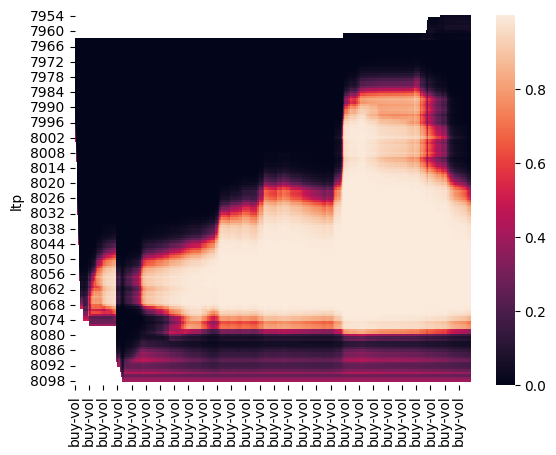

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.heatmap(instance.highLowdf[0])

### no sigmoid

<Axes: ylabel='ltp'>

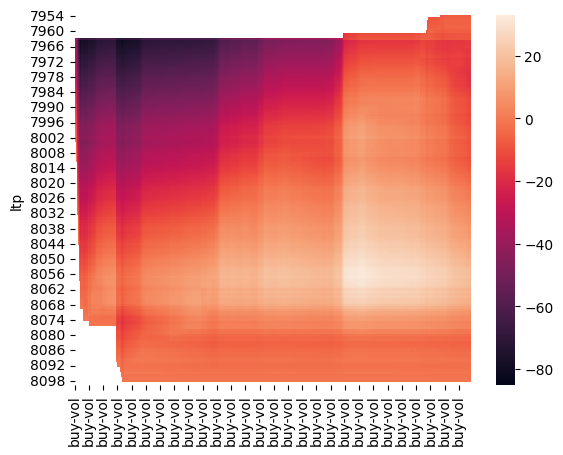

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.heatmap(instance.highLowdf[0])

<Axes: ylabel='ltp'>

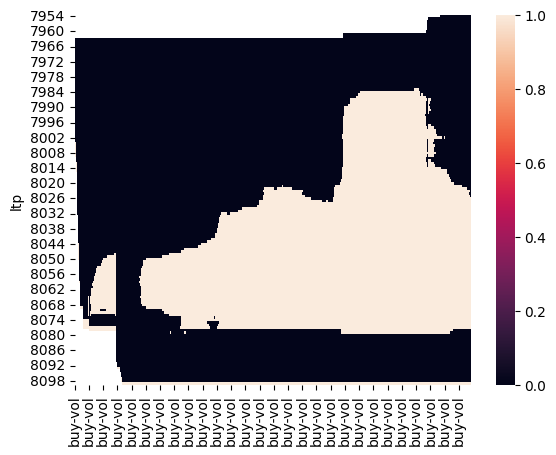

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.heatmap(instance.highLowdf[0])

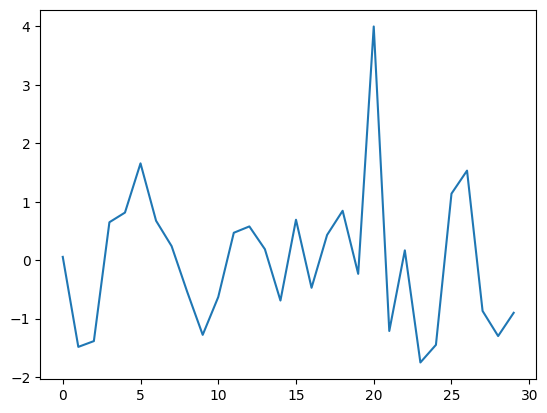

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#x = np.random.randn(30)
plt.plot(x)
plt.show()




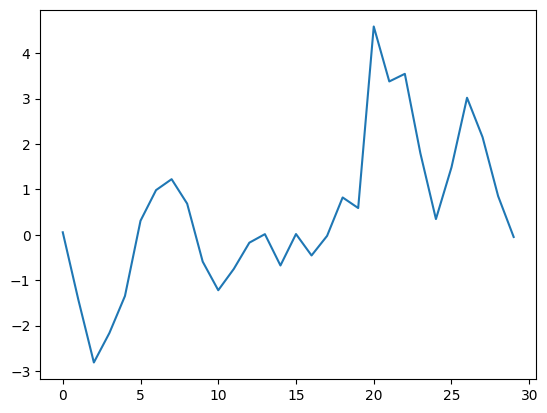

In [38]:
y = x.cumsum()
plt.plot(y)
plt.show()

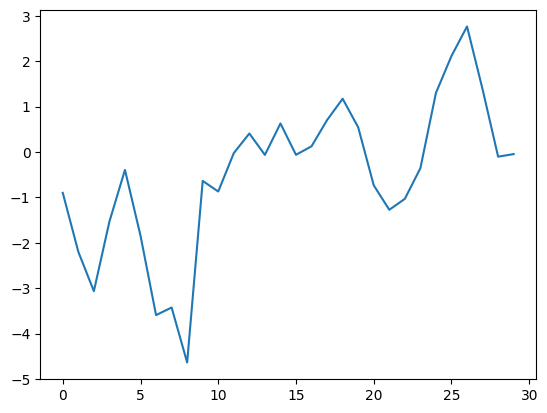

In [40]:
z = x[::-1].cumsum()
plt.plot(z)
plt.show()

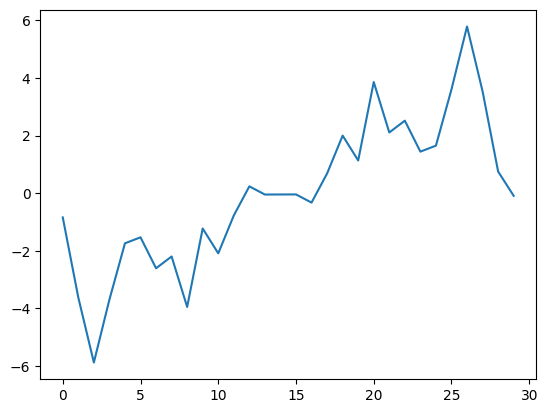

In [42]:
a = y+z
plt.plot(a)
plt.show()

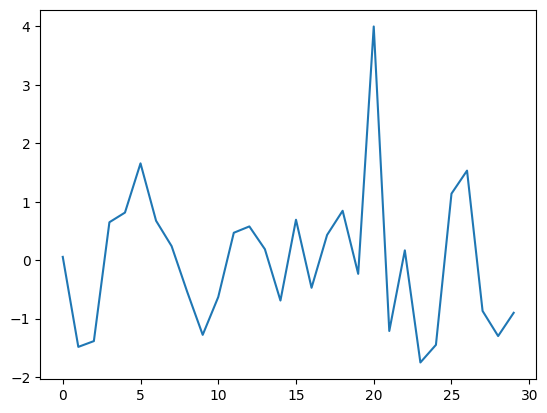

In [37]:
plt.plot(x)

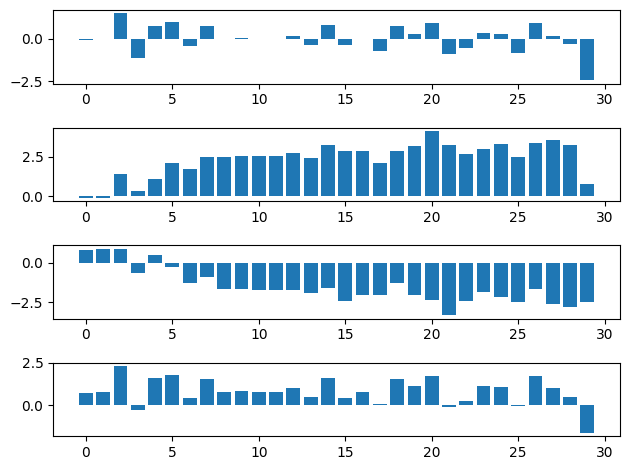

In [73]:
n = 30
data = np.random.randn(n)
nan_mask = np.random.choice([True, False], size=n, p=[0.2, 0.8])
data[nan_mask] = 0
x = data
y = x.cumsum()
z = x[::-1].cumsum()[::-1]
a = z+y
fig, ax = plt.subplots(4,1)
ax[0].bar(np.arange(n),x)
ax[1].bar(np.arange(n),y)
ax[2].bar(np.arange(n),z)
ax[3].bar(np.arange(n),a)
plt.tight_layout()
plt.show()



In [60]:
y

array([-0.6443838, -1.0239265,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [69]:
np.random.random_sample(19)

array([0.21400892, 0.47247311, 0.3158128 , 0.4107593 , 0.28047977,
       0.22407581, 0.21247616, 0.61638745, 0.28406867, 0.69220801,
       0.41082126, 0.86910744, 0.89455817, 0.4772847 , 0.69501236,
       0.03342025, 0.5064998 , 0.23549883, 0.94594053])